In [1]:
from torch import nn
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import numpy as np
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
  
# Download the MNIST Dataset
MNIST_dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
  
# DataLoader is used to load the dataset 
# for training
MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
                                     batch_size = 32,
                                     shuffle = True)

0.5%

49.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

92.8%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




2.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
class CifarB1Dataset(Dataset):
    def __init__(self, dic):
        self.data = dic[b'data']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = torch.tensor(self.data[idx])
        data = torch.reshape(data, (3,32,32))/255
        return data

In [6]:
def split_batch(batch):
    split_size = batch.size(dim=0)//2
    x1, x2 = torch.split(batch, split_size)
    return x1, x2

In [7]:
dic = unpickle("../cifar-10-batches-py/data_batch_1")
training_data = CifarB1Dataset(dic)
batch_size = 50
cifar_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

train_dataloader = cifar_loader

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, size = 32, chan = 3):
        super().__init__()
        self.conv =  nn.Sequential(nn.Conv2d(chan,8,3,stride=1,padding=1),
                                     torch.nn.ReLU(),
                                     nn.Conv2d(8,16,4,stride=2,padding=1),
                                     torch.nn.ReLU()
        )
        
        self.encoder = nn.Sequential(nn.Linear((size//2)*(size//2)*16, 256),
                                     torch.nn.ReLU(),
                                     nn.Linear(256,128),
                                     torch.nn.ReLU(),
                                     nn.Linear(128,64),
                                     torch.nn.ReLU(),
                                     nn.Linear(64,36),
                                     torch.nn.ReLU()
        )
        
        self.upconv = nn.Sequential(nn.ConvTranspose2d(1,3,3,stride = 2, padding = 1),
                                    torch.nn.ReLU(),
                                    nn.ConvTranspose2d(3,8,3,stride = 1, padding = 1),
                                    torch.nn.ReLU()
        )
        
        self.decoder = nn.Sequential(nn.Linear(8*11*11,1024),
                                     torch.nn.ReLU(),
                                     nn.Linear(1024,1536),
                                     torch.nn.ReLU(),
                                     #nn.Linear(64,128),
                                     #torch.nn.ReLU(),
                                     #nn.Linear(128,256),
                                     #torch.nn.ReLU(),
                                     nn.Linear(1536,size*size*chan),
                                     torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size = 0
        if len(x.size()) > 3:
            batch_size = x.size()[0]
        x = self.conv(x)
        x = torch.flatten(x,1)
        x = self.encoder(x)
        x = torch.reshape(x, (batch_size,1,6,6))
        x = self.upconv(x)
        #rint(x.size())
        x = torch.flatten(x,1)
        x = self.decoder(x)
        #x = torch.reshape(x, (batch_size, 3, 32, 32))
        return x

In [9]:
class PMP_Encoder(nn.Module):
    def  __init__(self,d, chan):
        super().__init__()
        self.conv1 = nn.Conv2d(chan,32,4,stride=2, padding=1)
        self.conv2 = nn.Conv2d(32,32,4,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32,64,4,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64,64,4,stride=2, padding=1)
        self.fc = nn.Linear(64*2*2,256)
        self.z = nn.Linear(256, d)
    
    def forward(self, x1 , x2):
        x1 = F.relu(self.conv1(x1))
        x1 = F.relu(self.conv2(x1))
        x1 = F.relu(self.conv3(x1))
        z1 = F.relu(self.conv4(x1))
        #print(z1.size())
        x2 = F.relu(self.conv1(x2))
        x2 = F.relu(self.conv2(x2))
        x2 = F.relu(self.conv3(x2))
        z2 = F.relu(self.conv4(x2))
        z1 = torch.flatten(z1,1)
        z1 = F.relu(self.fc(z1))
        s1 = self.z(z1)
        z2 = torch.flatten(z2,1)
        z2 = F.relu(self.fc(z2))
        s2 = self.z(z2)
        return s1, s2

In [10]:
class PMP_Decoder(nn.Module):
    def  __init__(self, d, chan):
        super().__init__()
        self.fc1 = nn.Linear(d,256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256, 64*2*2)
        # Reshape into 64x4x4
        self.convt1 = nn.ConvTranspose2d(64, 64, 4,stride=2,padding=1)
        self.convt2 = nn.ConvTranspose2d(64, 32, 4,stride=2,padding=1)
        self.convt3 = nn.ConvTranspose2d(32, 32, 4,stride=2,padding=1)
        self.convt4 = nn.ConvTranspose2d(32, chan, 4,stride=2,padding=1)
    
    def forward(self, z1, z2, batch_size):
        z1 = F.relu(self.fc1(z1))
        z1 = F.relu(self.fc2(z1))
        z1 = F.relu(self.fc3(z1))
        z2 = F.relu(self.fc1(z2))
        z2 = F.relu(self.fc2(z2))
        z2 = F.relu(self.fc3(z2))
        #print(z1.size())
        #print(f"batch_size = {batch_size}")
        z1 = torch.reshape(z1, (batch_size, 64,2,2))
        z2 = torch.reshape(z2, (batch_size, 64,2,2))

        z1 = F.relu(self.convt1(z1))
        z1 = F.relu(self.convt2(z1))
        z1 = F.relu(self.convt3(z1))
        x1 = F.relu(self.convt4(z1))

        z2 = F.relu(self.convt1(z2))
        z2 = F.relu(self.convt2(z2))
        z2 = F.relu(self.convt3(z2))
        x2 = F.relu(self.convt4(z2))

        return x1, x2


In [11]:
class PMP(nn.Module):
    def __init__(self, d=10, chan=3, batch_size=2):
        super(PMP, self).__init__()
        self.d = d
        self.chan = chan
        self.batch_size = batch_size
        self.encoder = PMP_Encoder(self.d, self.chan)
        self.decoder = PMP_Decoder(self.d, self.chan)
    
    def forward(self, x1, x2):
        z1, z2 = self.encoder(x1, x2)
        x1_, x2_ = self.decoder(z1, z2, self.batch_size)
        return x1_, x2_

In [12]:
import torch.optim as optim
size = 32
channels = 3
net = PMP(batch_size=batch_size//2)
print(net)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(),
                             lr = 0.0005,
                             weight_decay = 1e-8)

PMP(
  (encoder): PMP_Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=256, out_features=256, bias=True)
    (z): Linear(in_features=256, out_features=10, bias=True)
  )
  (decoder): PMP_Decoder(
    (fc1): Linear(in_features=10, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (convt1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt3): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convt4): ConvTranspose2d(32, 3, kerne

In [19]:
for epoch in range(35):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        x1, x2 = split_batch(data.float())
        #print(x1.type())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x1_hat, x2_hat = net(x1,x2)
        loss = criterion(torch.cat((x1,x2),0), torch.cat((x1_hat, x2_hat), 0))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

[1,     1] loss: 0.000522
[2,     1] loss: 0.000505
[3,     1] loss: 0.000528
[4,     1] loss: 0.000509
[5,     1] loss: 0.000525
[6,     1] loss: 0.000499
[7,     1] loss: 0.000534
[8,     1] loss: 0.000507
[9,     1] loss: 0.000524
[10,     1] loss: 0.000525
[11,     1] loss: 0.000501
[12,     1] loss: 0.000532
[13,     1] loss: 0.000523
[14,     1] loss: 0.000494
[15,     1] loss: 0.000507
[16,     1] loss: 0.000493
[17,     1] loss: 0.000535
[18,     1] loss: 0.000523
[19,     1] loss: 0.000519
[20,     1] loss: 0.000495
[21,     1] loss: 0.000473
[22,     1] loss: 0.000504
[23,     1] loss: 0.000467
[24,     1] loss: 0.000529
[25,     1] loss: 0.000505
[26,     1] loss: 0.000494
[27,     1] loss: 0.000493
[28,     1] loss: 0.000523
[29,     1] loss: 0.000525
[30,     1] loss: 0.000503
[31,     1] loss: 0.000543
[32,     1] loss: 0.000519
[33,     1] loss: 0.000507
[34,     1] loss: 0.000459
[35,     1] loss: 0.000484


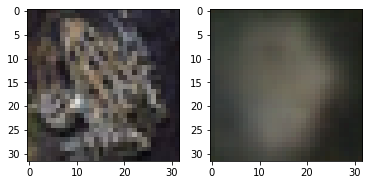

In [25]:
import matplotlib.pyplot as plt
im = torch.reshape(x1_hat[0],(channels,size,size))
im = im.detach().numpy()
im = np.moveaxis(im,0,2)
im_l = torch.reshape(x1[0],(channels,size,size)).detach().numpy()
im_l = np.moveaxis(im_l,0,2)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(im_l)
fig.add_subplot(1,2,2)
plt.imshow(im)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
im = torch.reshape(x1_hat[0],(3,32,32)) #torch.movedim(x1_hat,0,2)
im = im.detach().numpy()
#print(im.shape)
#print(x1_hat.size())
plt.imshow(im.T)
im_l = torch.reshape(x1[0],(3,32,32)).detach().numpy()
plt.imshow(im_l.T)
#X = dic[b'data']
#X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
#im1 =np.array(dic[b'data'][5]).reshape(3,32,32).T

print(im)
#plt.imshow(im1)